```
https://github.com/IPNL-POLYU/UrbanNavDataset/tree/master/UrbanNav-HK-Medium-Urban-1
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyquaternion
import json
import open3d as o3d
from PIL import Image
from projector import Projector
import yaml
import cv2
from pypcd import pypcd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
ROOT_DIR = "./datas/UrbanNav-HK-Medium-Urban-1"
IMG = ROOT_DIR + "/camera/left/1621218818.588944435.png"
PCD = ROOT_DIR + "/lidar/1621218818.559909105.pcd"
CALIB_FILE1 = ROOT_DIR + "/zed2_intrinsics.yaml"
CALIB_FILE2 = ROOT_DIR + "/extrinsic.yaml"

In [3]:
cam1 = cv2.FileStorage(CALIB_FILE1, cv2.FILE_STORAGE_READ)
cam2 = cv2.FileStorage(CALIB_FILE2, cv2.FILE_STORAGE_READ)

intrinsic = [
    cam1.getNode("projection_parameters").getNode("fx").real(), 0.0, cam1.getNode("projection_parameters").getNode("cx").real(),
    0.0, cam1.getNode("projection_parameters").getNode("fy").real(), cam1.getNode("projection_parameters").getNode("cy").real(),
    0.0, 0.0, 1.0
]
print(intrinsic)
intrinsic = np.array(intrinsic).reshape(3, 3)

imu_in_cam = cam2.getNode('LEFT_CAMERA_T_IMU').mat()      # imu in cam
imu_in_liar = cam2.getNode('CENTER_LiDAR_T_IMU').mat()  # imu in lidar
body_T_SPAN = cam2.getNode('body_T_SPAN').mat()

liar_in_cam = np.matmul(Projector.inverse_rigid_trans(imu_in_liar), imu_in_cam) # lidar in cam
extrinsic = liar_in_cam 
# extrinsic = Projector.inverse_rigid_trans(extrinsic)
print(extrinsic.tolist())

[264.9425, 0.0, 334.3975, 0.0, 264.79, 183.162, 0.0, 0.0, 1.0]
[[0.9995897597632202, 0.017170804625958682, -0.02292325554984076, -0.08518352335378968], [0.023146589349355498, -0.01292276982900426, 0.9996485569546115, 0.1257734831824673], [0.016868538110887142, -0.9997690560766732, -0.013314913952324876, -0.20411145029272001], [0.0, 0.0, 0.0, 0.0]]


(672, 376)


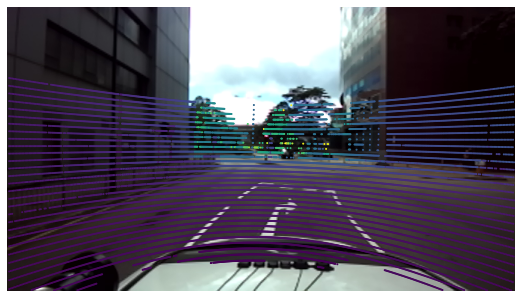

In [4]:
img = Image.open(IMG)
print(img.size)
pcd = o3d.io.read_point_cloud(PCD)
pts = np.asarray(pcd.points) # n, 3

points, coloring = Projector.map_pointcloud_to_image(img, pts, extrinsic, intrinsic)

fig, ax = plt.subplots(1, 1)
w, h = img.size
fig.set_size_inches(w/fig.dpi, h/fig.dpi)
ax.imshow(img)
ax.scatter(points[0, :], points[1, :], c=coloring, s=1)
ax.axis('off')
plt.savefig("./imgs/point_img.png")
plt.show()

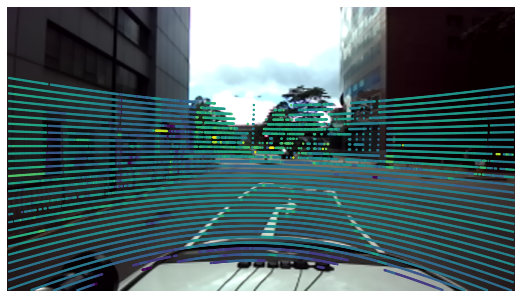

In [5]:
pc = pypcd.PointCloud.from_path(PCD)
pts = np.stack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z'], pc.pc_data['intensity']]).T

points, coloring = Projector.map_pointcloud_to_image(img, pts, extrinsic, intrinsic, coloring=Projector.Coloring.INTENSITY)

fig, ax = plt.subplots(1, 1)
w, h = img.size
fig.set_size_inches(w/fig.dpi, h/fig.dpi)
ax.imshow(img)
ax.scatter(points[0, :], points[1, :], c=coloring, s=2)
ax.axis('off')
plt.savefig("./imgs/point_img2.png")
plt.show()